In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import muon as mu
from muon import prot as pt
import os
import h5py
from mudata import MuData
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.sparse import csr_array
import anndata as ad
from sklearn.mixture import GaussianMixture  # different in updated sklearn (prev GMM)
from sklearn.metrics import confusion_matrix
from matplotlib.colors import rgb2hex
import milopy  # had to revert markupsafe (2.0.1) for updated version issue
import milopy.core as milo
import itertools
from distinctipy import distinctipy

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/si

In [2]:
def remove_recompute(adata):
    del adata.obsm['X_umap'], adata.obsm['X_pca'], adata.obsp, adata.uns
    sc.tl.pca(adata, svd_solver='auto')
    sc.pp.neighbors(adata)  # using with default parameters
    sc.tl.umap(adata)
    # sc.tl.diffmap(adata)
    return adata

def encode_replicates(adata, rep_dict):
    rep = [None] * adata.shape[0]
    for z in np.arange(adata.shape[0]):
        if np.sum(adata.obsm['hash_onoff'][z]) > 0:
            z_arg = np.argmax(adata.obsm['hash_onoff'][z])
            rep[z] = 'R{}'.format(z_arg+1)
        else:
            rep[z] = 'R0'
    return rep

def build_samplerep(adata, sample_slot, replicate_slot):
    sample_rep = [None] * adata.shape[0]
    for r in np.arange(adata.shape[0]):
        sample_rep[r] = str(adata.obs[sample_slot][r]) + ' ' + str(adata.obs[replicate_slot][r])
    return sample_rep


def group_nhoods(adata, min_connect, max_difflfc):
    adj_nhood = np.zeros((adata.obsm['nhoods'].shape[1], adata.obsm['nhoods'].shape[1]))

    # only considering single cells belonging to more than one
    overlap_ind = np.where(np.sum(adata.obsm['nhoods'], axis=1) > 1)[0]
    for g in overlap_ind:
        nhood_ind = np.where(adata.obsm['nhoods'][g, :].todense() == 1)[1]
        ij = list(itertools.permutations(nhood_ind, 2))
        for q in ij:
            adj_nhood[q] = adj_nhood[q] + 1

    # still need to filter adj matrix entries to zero by connections (< 3) and LFC match (diff > 0.25?)
    nonzero_ind = np.where(adj_nhood > 0)
    logFC = adata.uns['nhood_adata'].obs['logFC']
    for f in np.arange(len(nonzero_ind[0])):
        if adj_nhood[nonzero_ind[0][f], nonzero_ind[1][f]] < min_connect or abs(logFC[nonzero_ind[0][f]] - logFC[nonzero_ind[1][f]]) > max_difflfc:
            adj_nhood[nonzero_ind[0][f], nonzero_ind[1][f]] = 0

    return adj_nhood


def plot_nhood_clusters(adata, cluster_labels, title, alpha=0.1, min_size=10, plot_edges=False):
    nhood_adata = adata.uns["nhood_adata"].copy()

    nhood_adata.obs["graph_color"] = cluster_labels
    nhood_adata.obs["graph_color"] = nhood_adata.obs["graph_color"].astype('category')

    clust_col = distinctipy.get_colors(len(np.unique(nhood_adata.obs["graph_color"])))
    clust_pal = {np.unique(nhood_adata.obs["graph_color"])[i]: clust_col[i] for i in range(len(clust_col))}

    nhood_adata.obs.loc[nhood_adata.obs["SpatialFDR"] > alpha, "graph_color"] = np.nan

    # plotting order
    ordered = nhood_adata.obs.sort_values('SpatialFDR', na_position='last').index[::-1]
    nhood_adata = nhood_adata[ordered]

    sc.pl.embedding(nhood_adata, "X_milo_graph",
                    color="graph_color", palette=clust_pal,
                    size=adata.uns["nhood_adata"].obs["Nhood_size"] * min_size,
                    edges=plot_edges, neighbors_key="nhood",
                    frameon=False,
                    title=title
                    )

    return nhood_adata.obs["graph_color"], clust_pal


def plot_durable_clusters(adata, cluster_labels, title, alpha=0.1, beta=0.5, min_size=10, plot_edges=False):
    nhood_adata = adata.uns["nhood_adata"].copy()

    nhood_adata.obs["graph_color"] = cluster_labels
    nhood_adata.obs["graph_color"] = nhood_adata.obs["graph_color"].astype('category')

    clust_col = distinctipy.get_colors(len(np.unique(nhood_adata.obs["graph_color"])))
    clust_pal = {np.unique(nhood_adata.obs["graph_color"])[i]: clust_col[i] for i in range(len(clust_col))}

    nhood_adata.obs.loc[nhood_adata.obs["SpatialFDR"] < alpha, "graph_color"] = np.nan
    nhood_adata.obs.loc[nhood_adata.obs["logFC"] > beta, "graph_color"] = np.nan
    nhood_adata.obs.loc[nhood_adata.obs["logFC"] < -beta, "graph_color"] = np.nan

    sc.pl.embedding(nhood_adata, "X_milo_graph",
                    color="graph_color", palette=clust_pal,
                    size=adata.uns["nhood_adata"].obs["Nhood_size"] * min_size,
                    edges=plot_edges, neighbors_key="nhood",
                    frameon=False,
                    title=title
                    )

    return nhood_adata.obs["graph_color"], clust_pal


def get_sc_louvain(adata, cluster_slot='louvain'):
    louvain_onehot = np.zeros((adata.uns['nhood_adata'].obs[cluster_slot].shape[0], (np.unique(adata.uns['nhood_adata'].obs[cluster_slot])[-2] + 1).astype('int')))
    for c in adata.uns['nhood_adata'].obs[cluster_slot].index:
        if adata.uns['nhood_adata'].obs[cluster_slot][c] < float('inf'):
            louvain_onehot[int(c), adata.uns['nhood_adata'].obs[cluster_slot][c].astype('int')] = 1

    # get single-cell louvain neighborhood cluster labels
    sc_onehot = adata.obsm['nhoods']*louvain_onehot
    sc_louvain = np.zeros(sc_onehot.shape[0])
    for t in np.arange(sc_onehot.shape[0]):
        if np.sum(sc_onehot[t, :]) == 0:
            sc_louvain[t] = -1
        else:
            sc_louvain[t] = np.argmax(sc_onehot[t, :])

    return sc_louvain.astype('int')

In [3]:
rna_sing = sc.read('/Users/anasuyadighe/Downloads/cpi-cd40-main/Round4_celltypes_collapsed.h5ad')

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [4]:
all_d15 = []
unt_d15 = np.where(rna_sing.obs['sample'] == 'P5-T0-d15')[0]
trt_d15 = np.where(rna_sing.obs['sample'] == 'P6-T4-d15')[0]
adata = rna_sing[np.concatenate((unt_d15, trt_d15)), :]
all_d15.append(adata.copy())

In [5]:
concatenated_data = ad.concat(all_d15, join='outer')
concatenated_data

AnnData object with n_obs × n_vars = 9321 × 19059
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'hashing', 'leiden', 'hashtag', 'CD45', 'leiden_0.6', 'leiden_new'
    obsm: 'X_pca', 'X_umap', 'hash_onoff'

In [6]:
concatenated_data = remove_recompute(concatenated_data)

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


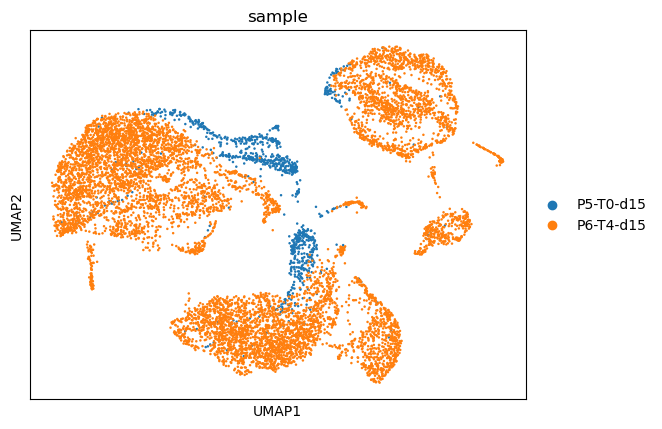

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


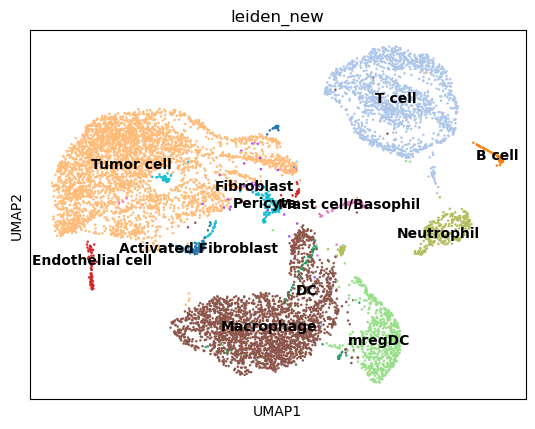

In [7]:
sc.pl.umap(concatenated_data, color = 'sample')
sc.pl.umap(concatenated_data, color = 'leiden_new', legend_loc = 'on data')